In [1]:
from pathlib import Path
path_folder = Path("/Users/keithlowton/Desktop/Ks/Python code/Kaggle/London Energy Data")
print(path_folder.exists())
print(path_folder)

True
/Users/keithlowton/Desktop/Ks/Python code/Kaggle/London Energy Data


In [48]:
import math
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor


### Functions

In [24]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

In [27]:
def plot_lag(x, lag=1, ax=None, **kwargs):
    x_ = x.shift(lag)
    y_ = x
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line = dict(
        color="C3",
    )

    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line, lowess=True, ax=ax, **kwargs)

    # Adding correlation on plot
    at = AnchoredText(
        f"{y_.corr(x_):.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


In [28]:
def plot_autocorrelation(x, lags=6, lagplot_kwargs={}, **kwargs):
    kwargs.setdefault("nrows", 2)
    kwargs.setdefault("ncols", math.ceil(lags / 2))
    kwargs.setdefault("figsize", (kwargs["ncols"] * 2, 2 * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(2 * kwargs["ncols"])):
        if k + 1 <= lags:
            ax = plot_lag(x, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag #{k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis("off")
    plt.setp(axs[-1, :], xlabel=x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


In [31]:
def create_lag_features(df, lags=2):
  y = df_avg_consumption.loc[:, "consumption"]
  for lag in range(lags):
    df[f"lag_{lag + 1}"] = y.shift(lag + 1)
  return df

In [44]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int, return_Xy: bool = False):
    """
    Time delay embedding
    Time series for supervised learning

    :param series: time series as pd.Series
    :param n_lags: number of past values to used as explanatory variables
    :param horizon: how many values to forecast
    :param return_Xy: whether to return the lags split from future observations

    :return: pd.DataFrame with reconstructed time series
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = "Series"
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    df_list = [series.shift(i) for i in n_lags_iter]
    df = pd.concat(df_list, axis=1).dropna()
    df.columns = [f"{name}(t-{j - 1})" if j > 0 else f"{name}(t+{np.abs(j) + 1})" for j in n_lags_iter]

    df.columns = [re.sub("t-0", "t", x) for x in df.columns]

    if not return_Xy:
        return df

    is_future = df.columns.str.contains("\+")

    X = df.iloc[:, ~is_future]
    Y = df.iloc[:, is_future]
    if Y.shape[1] == 1:
        Y = Y.iloc[:, 0]

    return X, Y


### Read in the data

#### Energy data

In [83]:

df = pd.read_csv(os.path.join(path_folder, "data/london_energy.csv"), sep=",")
print(df.shape)
df.head()

(3510433, 3)


,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


In [84]:
print(df.isna().sum())

LCLid    0
Date     0
KWH      0
dtype: int64


#### Weather data

In [100]:
df_weather = pd.read_csv(os.path.join(path_folder, "data/london_weather.csv"), sep=",")
print(df_weather.isna().sum())
df_weather.head()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [101]:
# Parsing dates
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")

# Filling missing values through interpolation
df_weather = df_weather.interpolate(method="ffill")

df_weather.set_index('date', inplace=True)

/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_7563/2762098758.py:5: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather = df_weather.interpolate(method="ffill")


In [66]:
df_weather_ds = []
for col in df_weather:
    print(col)
    if str(col) != "date":
        col_df = time_delay_embedding(df_weather[col], n_lags=12, horizon=6)
        df_weather_ds.append(col_df)

df_weather = pd.concat(df_weather_ds, axis=1).dropna()
df_weather["date"] = df_weather.index
df_weather = df_weather.reset_index(drop=True)
df_weather.head()

cloud_cover
sunshine
global_radiation
max_temp
mean_temp
min_temp
precipitation
pressure
snow_depth


,cloud_cover(t-11),cloud_cover(t-10),cloud_cover(t-9),cloud_cover(t-8),cloud_cover(t-7),cloud_cover(t-6),cloud_cover(t-5),cloud_cover(t-4),cloud_cover(t-3),cloud_cover(t-2),...,snow_depth(t-2),snow_depth(t-1),snow_depth(t),snow_depth(t+1),snow_depth(t+2),snow_depth(t+3),snow_depth(t+4),snow_depth(t+5),snow_depth(t+6),date
0,2.0,6.0,5.0,8.0,6.0,5.0,8.0,8.0,4.0,7.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1979-01-13
1,6.0,5.0,8.0,6.0,5.0,8.0,8.0,4.0,7.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1979-01-14
2,5.0,8.0,6.0,5.0,8.0,8.0,4.0,7.0,1.0,3.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1979-01-15
3,8.0,6.0,5.0,8.0,8.0,4.0,7.0,1.0,3.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1979-01-16
4,6.0,5.0,8.0,8.0,4.0,7.0,1.0,3.0,1.0,7.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1979-01-17


### Process the data

In [85]:
df_avg_consumption = df.groupby("Date")["KWH"].mean()
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"])
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


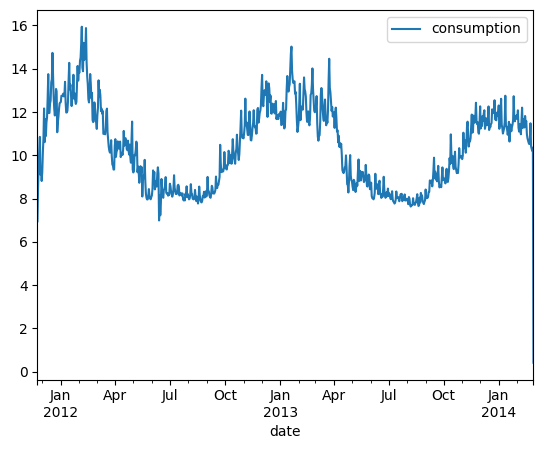

In [86]:
df_avg_consumption.plot(x="date", y="consumption")
plt.show()

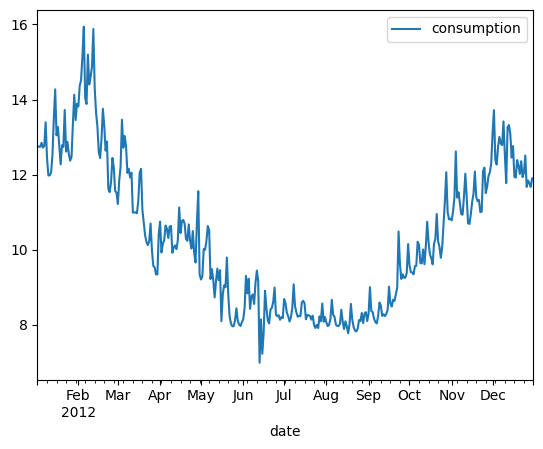

In [87]:
df_avg_consumption.query("date > '2012-01-01' & date < '2013-01-01'").plot(x="date", y="consumption")
plt.show()

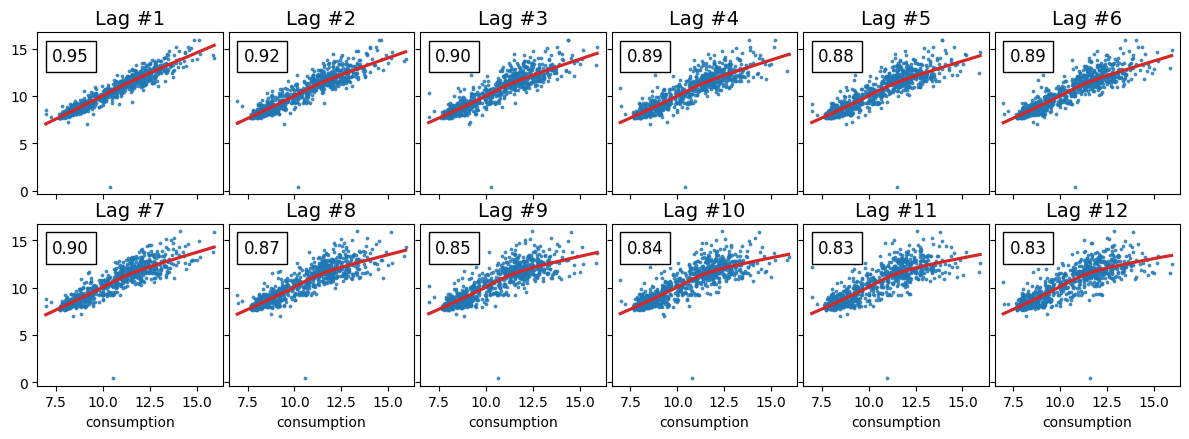

In [97]:
_ = plot_autocorrelation(df_avg_consumption["consumption"], lags=12)

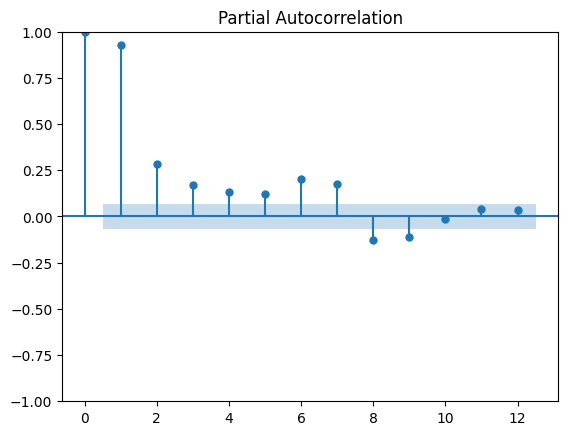

In [98]:
_ = plot_pacf(df_avg_consumption["consumption"], lags=12)

### Preprocess the data

In [99]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption = create_lag_features(df_avg_consumption, lags=12)

df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2011-11-23,6.952692,2,327,11,4,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-11-24,8.536480,3,328,11,4,2011,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-11-25,9.499781,4,329,11,4,2011,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-11-26,10.267707,5,330,11,4,2011,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-11-27,10.850805,6,331,11,4,2011,10.267707,9.499781,8.536480,6.952692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Merge data

In [105]:
# Enhancing consumption dataset with weather information
df_avg_consumption = df_avg_consumption.merge(df_weather, how="inner", on="date")
df_avg_consumption = df_avg_consumption.fillna(0)
df_avg_consumption.head()

,date,consumption,day_of_week,day_of_year,month,quarter,year,lag_1,lag_2,lag_3,...,snow_depth_x,cloud_cover_y,sunshine_y,global_radiation_y,max_temp_y,mean_temp_y,min_temp_y,precipitation_y,pressure_y,snow_depth_y
0,2011-11-23,6.952692,2,327,11,4,2011,0.000000,0.000000,0.000000,...,0.0,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0
1,2011-11-24,8.536480,3,328,11,4,2011,6.952692,0.000000,0.000000,...,0.0,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0
2,2011-11-25,9.499781,4,329,11,4,2011,8.536480,6.952692,0.000000,...,0.0,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0
3,2011-11-26,10.267707,5,330,11,4,2011,9.499781,8.536480,6.952692,...,0.0,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0
4,2011-11-27,10.850805,6,331,11,4,2011,10.267707,9.499781,8.536480,...,0.0,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0


### Granger causality test

In [106]:
all_cols = list(df_avg_consumption.columns)
all_cols.remove("date")
print(all_cols)

['consumption', 'day_of_week', 'day_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'cloud_cover_x', 'sunshine_x', 'global_radiation_x', 'max_temp_x', 'mean_temp_x', 'min_temp_x', 'precipitation_x', 'pressure_x', 'snow_depth_x', 'cloud_cover_y', 'sunshine_y', 'global_radiation_y', 'max_temp_y', 'mean_temp_y', 'min_temp_y', 'precipitation_y', 'pressure_y', 'snow_depth_y']


In [107]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 6 # represents the maximum number of past time periods to look for potential causality. We cap ours at 6 months
leading_indicators = []

for x in all_cols:
    gc_res = grangercausalitytests(df_avg_consumption[["consumption", x]], maxlag=maxlag, verbose=0)
    leading_indicators_tmp = []
    for lag in range(1, maxlag+1):
        ftest_stat = gc_res[lag][0]['ssr_ftest'][0]
        ftest_pvalue = gc_res[lag][0]['ssr_ftest'][1]
        if ftest_pvalue <= 0.05:
            leading_indicators_tmp.append({'x': x, 'lag': lag, 'ftest_pvalue': ftest_pvalue, 'ftest_stat': ftest_stat, 'xlabel': f'{x}__{lag}_mths_ago'})
    if leading_indicators_tmp:
        leading_indicators.append(max(leading_indicators_tmp, key=lambda x:x['ftest_stat']))

# Display leading indicators as a dataframe
pd.DataFrame(leading_indicators).reset_index(drop=True).reset_index(drop=True)

/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/keithlowton/anaconda3/envs/Time_series/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print 

,x,lag,ftest_pvalue,ftest_stat,xlabel
0,day_of_week,6,3.386795e-44,41.490248,day_of_week__6_mths_ago
1,year,1,3.133463e-02,4.650401,year__1_mths_ago
2,lag_1,5,5.903559e-07,7.562535,lag_1__5_mths_ago
3,lag_2,6,4.098893e-12,11.268655,lag_2__6_mths_ago
4,lag_3,5,1.315147e-20,21.885301,lag_3__5_mths_ago
5,lag_4,4,1.661439e-21,27.587979,lag_4__4_mths_ago
6,lag_5,3,2.152490e-20,33.438948,lag_5__3_mths_ago
7,lag_6,2,3.111335e-22,52.628813,lag_6__2_mths_ago
8,lag_7,6,1.675680e-03,3.574285,lag_7__6_mths_ago
9,lag_8,6,6.133424e-04,3.984663,lag_8__6_mths_ago


### Test-train data

In [78]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 190)
(216, 190)


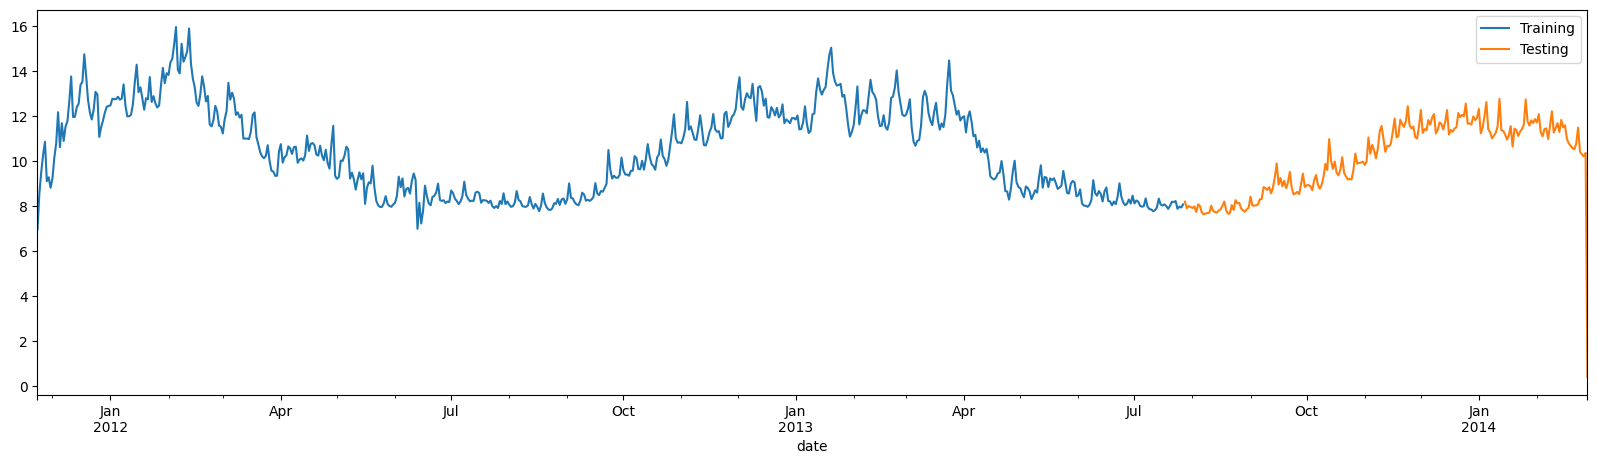

In [79]:
figure, ax = plt.subplots(figsize=(20, 5))
training_data.plot(ax=ax, label="Training", x="date", y="consumption")
testing_data.plot(ax=ax, label="Testing", x="date", y="consumption")
plt.show()

In [80]:
print(list(training_data.columns))

['date', 'consumption', 'day_of_week', 'day_of_year', 'month', 'quarter', 'year', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth', 'cloud_cover(t-11)', 'cloud_cover(t-10)', 'cloud_cover(t-9)', 'cloud_cover(t-8)', 'cloud_cover(t-7)', 'cloud_cover(t-6)', 'cloud_cover(t-5)', 'cloud_cover(t-4)', 'cloud_cover(t-3)', 'cloud_cover(t-2)', 'cloud_cover(t-1)', 'cloud_cover(t)', 'cloud_cover(t+1)', 'cloud_cover(t+2)', 'cloud_cover(t+3)', 'cloud_cover(t+4)', 'cloud_cover(t+5)', 'cloud_cover(t+6)', 'sunshine(t-11)', 'sunshine(t-10)', 'sunshine(t-9)', 'sunshine(t-8)', 'sunshine(t-7)', 'sunshine(t-6)', 'sunshine(t-5)', 'sunshine(t-4)', 'sunshine(t-3)', 'sunshine(t-2)', 'sunshine(t-1)', 'sunshine(t)', 'sunshine(t+1)', 'sunshine(t+2)', 'sunshine(t+3)', 'sunshine(t+4)', 'sunshine(t+5)', 'sunshine(t+6)', 'global_radiat

In [81]:
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data.drop(["consumption"], axis=1)
y_train = training_data["consumption"]

X_test = testing_data.drop(["consumption"], axis=1)
y_test = testing_data["consumption"]


### Feature importance

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
importance_scores = pd.Series(dict(zip(X_tr.columns, model.feature_importances_)))

top_10_features = importance_scores.sort_values(ascending=False)[:10]
top_10_features

In [82]:
# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

### Baseline results

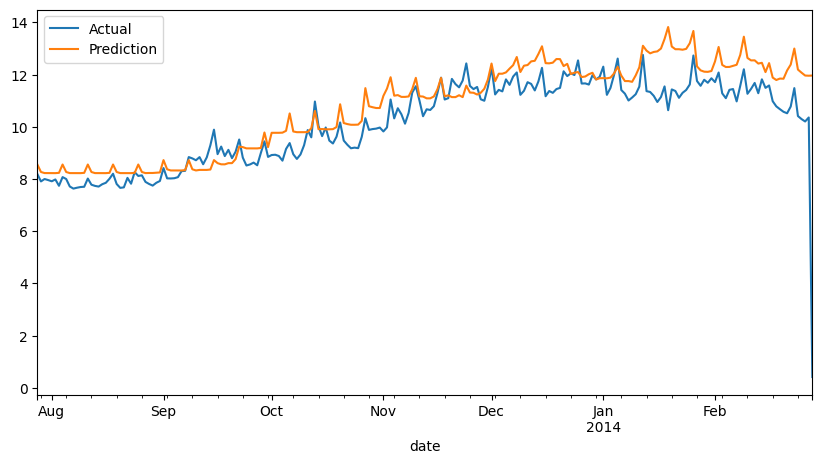

MAE: 0.726046583678707
MSE: 1.3039994731161895
MAPE: 0.19346012873545185


In [25]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)

### Lag feature model

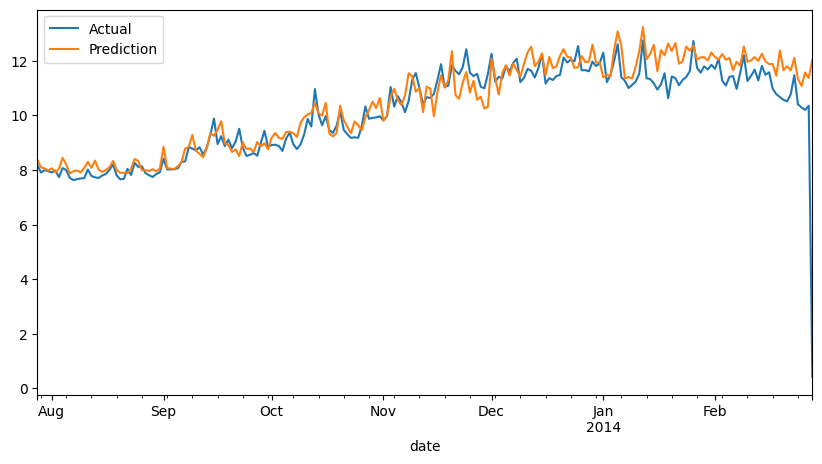

MAE: 0.47940389041017006
MSE: 0.92609194038901
MAPE: 0.16954584075848292


In [40]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)